In [1]:
# Cell 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Text Processing
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Embedding
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Word Embeddings
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV

# Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# For reproducibility
import random
import os

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')


C:\Users\roy.xu23\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\roy.xu23\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\roy.xu23\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Cell 2: Load Dataset
# Paths to CSV files
true_path = 'True.csv'
fake_path = 'Fake.csv'

# Load CSVs
true_df = pd.read_csv(true_path)
fake_df = pd.read_csv(fake_path)

# Add a label column: 0 for True, 1 for Fake
true_df['label'] = 0
fake_df['label'] = 1

# Combine the datasets
df = pd.concat([true_df, fake_df], ignore_index=True)

# Display the first few rows
df.head()


,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


Dataset shape: (44898, 5)

Dataset columns: ['title', 'text', 'subject', 'date', 'label']

Missing values:
 title      0
text       0
subject    0
date       0
label      0
dtype: int64


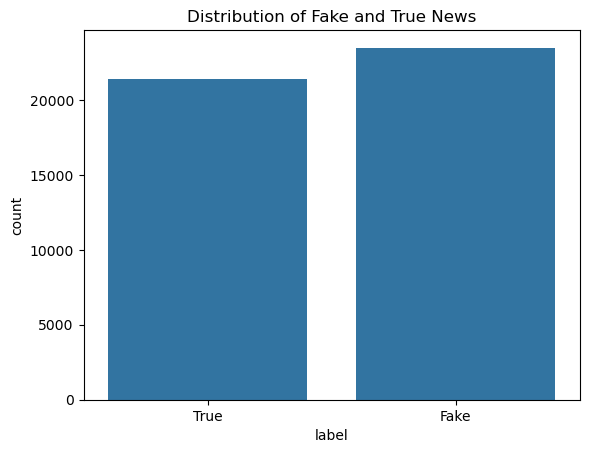


Sample True News:
WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs t

In [5]:
# Cell 3: Data Exploration
print("Dataset shape:", df.shape)
print("\nDataset columns:", df.columns.tolist())

# Check for missing values
print("\nMissing values:\n", df.isnull().sum())

# Distribution of labels
sns.countplot(x='label', data=df)
plt.title('Distribution of Fake and True News')
plt.xticks([0,1], ['True', 'Fake'])
plt.show()

# Display some sample texts
print("\nSample True News:")
print(df[df['label'] == 0]['text'].iloc[0])

print("\nSample Fake News:")
print(df[df['label'] == 1]['text'].iloc[0])


In [7]:
# Cell 4: Data Preprocessing Functions
# Initialize stopwords
stop_words = set(stopwords.words('english'))

def preprocess_text(text, remove_stopwords=True, to_lower=True, remove_punctuation=True, perform_stemming=False, perform_lemmatization=False):
    # Remove HTML tags if any
    text = re.sub(r'<.*?>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove punctuation
    if remove_punctuation:
        text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Lowercase
    if to_lower:
        text = text.lower()
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    if remove_stopwords:
        tokens = [word for word in tokens if word not in stop_words]
    
    # Optional: Stemming
    if perform_stemming:
        from nltk.stem import PorterStemmer
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(word) for word in tokens]
    
    # Optional: Lemmatization
    if perform_lemmatization:
        from nltk.stem import WordNetLemmatizer
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)


In [9]:
# Cell 5: Apply Different Preprocessing Steps
# Define different preprocessing configurations
preprocessing_steps = {
    'Basic': {'remove_stopwords': False, 'to_lower': False, 'remove_punctuation': False},
    'Lowercase': {'remove_stopwords': False, 'to_lower': True, 'remove_punctuation': False},
    'Lowercase & Remove Punctuation': {'remove_stopwords': False, 'to_lower': True, 'remove_punctuation': True},
    'Lowercase, Remove Punctuation & Stopwords': {'remove_stopwords': True, 'to_lower': True, 'remove_punctuation': True},
    'Full Preprocessing': {'remove_stopwords': True, 'to_lower': True, 'remove_punctuation': True, 'perform_stemming': True}
}

# Create a dictionary to store processed texts
processed_texts = {}

for step, params in preprocessing_steps.items():
    print(f"Applying preprocessing: {step}")
    processed = df['text'].apply(lambda x: preprocess_text(x, 
                                                           remove_stopwords=params.get('remove_stopwords', False),
                                                           to_lower=params.get('to_lower', False),
                                                           remove_punctuation=params.get('remove_punctuation', False),
                                                           perform_stemming=params.get('perform_stemming', False),
                                                           perform_lemmatization=params.get('perform_lemmatization', False)))
    processed_texts[step] = processed

# Example: Display processed texts
for step in preprocessing_steps.keys():
    print(f"\nSample text after '{step}' preprocessing:")
    print(processed_texts[step].iloc[0])


Applying preprocessing: Basic
Applying preprocessing: Lowercase
Applying preprocessing: Lowercase & Remove Punctuation
Applying preprocessing: Lowercase, Remove Punctuation & Stopwords
Applying preprocessing: Full Preprocessing

Sample text after 'Basic' preprocessing:
WASHINGTON ( Reuters ) - The head of a conservative Republican faction in the U.S. Congress , who voted this month for a huge expansion of the national debt to pay for tax cuts , called himself a “ fiscal conservative ” on Sunday and urged budget restraint in . In keeping with a sharp pivot under way among Republicans , U.S. Representative Mark Meadows , speaking on CBS ’ “ Face the Nation , ” drew a hard line on federal spending , which lawmakers are bracing to do battle over in January . When they return from the holidays on Wednesday , lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues , such as immigration policy , even as the November congressional election campaigns 

In [28]:
import os
import zipfile
import requests

def download_glove(destination_path='glove.6B.zip'):
    url = "http://nlp.stanford.edu/data/glove.6B.zip"
    response = requests.get(url, stream=True)
    with open(destination_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=128):
            f.write(chunk)
    print("Downloaded GloVe embeddings.")

def extract_glove(zip_path='glove.6B.zip', extract_to='.'):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("Extracted GloVe embeddings.")

# Download and extract
download_glove()
extract_glove()


Downloaded GloVe embeddings.
Extracted GloVe embeddings.


In [29]:
# Cell 6: Feature Extraction - Embedding Methods
# Define embedding methods
embedding_methods = ['OneHot', 'Word2Vec', 'GloVe']

# We will use the 'Full Preprocessing' for embedding
X = processed_texts['Full Preprocessing']
y = df['label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Function for One-Hot Encoding
def one_hot_encode(train_texts, test_texts, max_features=5000):
    vectorizer = CountVectorizer(max_features=max_features)
    X_train_enc = vectorizer.fit_transform(train_texts).toarray()
    X_test_enc = vectorizer.transform(test_texts).toarray()
    return X_train_enc, X_test_enc, vectorizer

# Function for Word2Vec
def word2vec_embed(train_texts, test_texts, vector_size=100, window=5, min_count=1):
    # Tokenize
    train_tokens = [text.split() for text in train_texts]
    test_tokens = [text.split() for text in test_texts]
    
    # Train Word2Vec
    w2v_model = Word2Vec(sentences=train_tokens, vector_size=vector_size, window=window, min_count=min_count, workers=4)
    
    # Function to get average Word2Vec vectors
    def get_avg_w2v(tokens, model, vector_size):
        vectors = [model.wv[word] for word in tokens if word in model.wv]
        if len(vectors) == 0:
            return np.zeros(vector_size)
        else:
            return np.mean(vectors, axis=0)
    
    X_train_w2v = np.array([get_avg_w2v(tokens, w2v_model, vector_size) for tokens in train_tokens])
    X_test_w2v = np.array([get_avg_w2v(tokens, w2v_model, vector_size) for tokens in test_tokens])
    
    return X_train_w2v, X_test_w2v, w2v_model

# Function to load GloVe embeddings
def load_glove_embeddings(glove_file_path, embedding_dim=100):
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = ''.join(values[:-embedding_dim])
            coefs = np.asarray(values[-embedding_dim:], dtype='float32')
            embeddings_index[word] = coefs
    print(f'Loaded {len(embeddings_index)} word vectors from GloVe.')
    return embeddings_index

# Function for GloVe Embedding
def glove_embed(train_texts, test_texts, embeddings_index, embedding_dim=100):
    # Tokenize
    train_tokens = [text.split() for text in train_texts]
    test_tokens = [text.split() for text in test_texts]
    
    # Function to get average GloVe vectors
    def get_avg_glove(tokens, embeddings, dim):
        vectors = [embeddings[word] for word in tokens if word in embeddings]
        if len(vectors) == 0:
            return np.zeros(dim)
        else:
            return np.mean(vectors, axis=0)
    
    X_train_glove = np.array([get_avg_glove(tokens, embeddings_index, embedding_dim) for tokens in train_tokens])
    X_test_glove = np.array([get_avg_glove(tokens, embeddings_index, embedding_dim) for tokens in test_tokens])
    
    return X_train_glove, X_test_glove

# Apply One-Hot Encoding
X_train_oh, X_test_oh, vectorizer_oh = one_hot_encode(X_train, X_test, max_features=5000)
print("One-Hot Encoding shape:", X_train_oh.shape)

# Apply Word2Vec
X_train_w2v, X_test_w2v, w2v_model = word2vec_embed(X_train, X_test, vector_size=100)
print("Word2Vec Embedding shape:", X_train_w2v.shape)

# Load GloVe embeddings
glove_path = 'glove.6B.100d.txt'
embeddings_glove = load_glove_embeddings(glove_path, embedding_dim=100)

# Apply GloVe Embedding
X_train_glove, X_test_glove = glove_embed(X_train, X_test, embeddings_glove, embedding_dim=100)
print("GloVe Embedding shape:", X_train_glove.shape)


One-Hot Encoding shape: (35918, 5000)
Word2Vec Embedding shape: (35918, 100)
Loaded 400000 word vectors from GloVe.
GloVe Embedding shape: (35918, 100)


In [32]:
# Cell 7: Define Feedforward Neural Network
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_sizes=[128, 64], output_size=1, dropout=0.5):
        super(FFNN, self).__init__()
        layers = []
        last_size = input_size
        for hidden in hidden_sizes:
            layers.append(nn.Linear(last_size, hidden))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            last_size = hidden
        layers.append(nn.Linear(last_size, output_size))
        layers.append(nn.Sigmoid())
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)


In [34]:
# Cell 8: Prepare Datasets and DataLoaders
class NewsDataset(Dataset):
    def __init__(self, features, labels):
        self.X = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(labels.values, dtype=torch.float32).unsqueeze(1)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Function to create DataLoaders
def create_dataloaders(X_train, X_test, y_train, y_test, batch_size=64):
    train_dataset = NewsDataset(X_train, y_train)
    test_dataset = NewsDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_loader, test_loader

# Example: Create DataLoaders for One-Hot Encoding
batch_size = 64
train_loader_oh, test_loader_oh = create_dataloaders(X_train_oh, X_test_oh, y_train, y_test, batch_size)


In [36]:
# Cell 9: Training and Evaluation Functions
def train_model(model, train_loader, criterion, optimizer, epochs=10, device='cpu'):
    model.to(device)
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_acc = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * X_batch.size(0)
            preds = (outputs >= 0.5).float()
            epoch_acc += (preds == y_batch).sum().item()
        
        epoch_loss /= len(train_loader.dataset)
        epoch_acc /= len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}')

def evaluate_model(model, test_loader, device='cpu'):
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = (outputs >= 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.numpy())
    acc = accuracy_score(all_labels, all_preds)
    print(f'Test Accuracy: {acc:.4f}')
    print('Classification Report:')
    print(classification_report(all_labels, all_preds, target_names=['True', 'Fake']))
    print('Confusion Matrix:')
    print(confusion_matrix(all_labels, all_preds))


In [38]:
# Cell 10: Train and Evaluate Models with Different Embeddings

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Define hyperparameters
hidden_sizes = [128, 64]
dropout = 0.5
epochs = 10
learning_rate = 0.001

# Dictionary to store results
results = {}

# Function to train and evaluate for a given embedding
def train_evaluate(embedding_name, X_train, X_test, y_train, y_test):
    print(f"\nTraining model with {embedding_name} embedding")
    
    # Create DataLoaders
    train_loader, test_loader = create_dataloaders(X_train, X_test, y_train, y_test, batch_size)
    
    # Define model
    input_size = X_train.shape[1]
    model = FFNN(input_size=input_size, hidden_sizes=hidden_sizes, dropout=dropout)
    
    # Define loss and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train the model
    train_model(model, train_loader, criterion, optimizer, epochs, device)
    
    # Evaluate the model
    evaluate_model(model, test_loader, device)
    
    # Save the model's accuracy
    # For simplicity, we'll capture the final test accuracy
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = (outputs >= 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.numpy())
    acc = accuracy_score(all_labels, all_preds)
    results[embedding_name] = acc

# One-Hot Encoding
train_evaluate('One-Hot Encoding', X_train_oh, X_test_oh, y_train, y_test)

# Word2Vec
train_evaluate('Word2Vec', X_train_w2v, X_test_w2v, y_train, y_test)

# GloVe
train_evaluate('GloVe', X_train_glove, X_test_glove, y_train, y_test)

# Compare Results
print("\nComparison of Embedding Methods:")
for method, acc in results.items():
    print(f"{method}: Test Accuracy = {acc:.4f}")


Using device: cpu

Training model with One-Hot Encoding embedding
Epoch 1/10 - Loss: 0.1176 - Accuracy: 0.9707
Epoch 2/10 - Loss: 0.0335 - Accuracy: 0.9936
Epoch 3/10 - Loss: 0.0215 - Accuracy: 0.9966
Epoch 4/10 - Loss: 0.0205 - Accuracy: 0.9969
Epoch 5/10 - Loss: 0.0159 - Accuracy: 0.9982
Epoch 6/10 - Loss: 0.0144 - Accuracy: 0.9991
Epoch 7/10 - Loss: 0.0174 - Accuracy: 0.9983
Epoch 8/10 - Loss: 0.0188 - Accuracy: 0.9985
Epoch 9/10 - Loss: 0.0160 - Accuracy: 0.9987
Epoch 10/10 - Loss: 0.0172 - Accuracy: 0.9987
Test Accuracy: 0.9955
Classification Report:
              precision    recall  f1-score   support

        True       0.99      1.00      1.00      4284
        Fake       1.00      0.99      1.00      4696

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

Confusion Matrix:
[[4268   16]
 [  24 4672]]

Training model with Word2Vec embedding
Epoch 1/10 - Loss: 0.1193 

In [39]:
# Cell 11: Hyperparameter Tuning with RandomizedSearch

# For simplicity, we'll tune the learning rate and hidden sizes
from itertools import product

def hyperparameter_tuning(embedding_name, X_train, X_test, y_train, y_test, param_grid, iterations=10):
    print(f"\nHyperparameter Tuning for {embedding_name} embedding")
    best_acc = 0
    best_params = {}
    
    # Generate random combinations
    param_combinations = list(product(*param_grid.values()))
    random.shuffle(param_combinations)
    param_combinations = param_combinations[:iterations]
    
    for params in param_combinations:
        lr, hidden1, hidden2 = params
        print(f"\nTraining with lr={lr}, hidden_sizes=[{hidden1}, {hidden2}]")
        
        # Create DataLoaders
        train_loader, test_loader = create_dataloaders(X_train, X_test, y_train, y_test, batch_size)
        
        # Define model
        input_size = X_train.shape[1]
        model = FFNN(input_size=input_size, hidden_sizes=[hidden1, hidden2], dropout=dropout)
        
        # Define loss and optimizer
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        # Train the model
        train_model(model, train_loader, criterion, optimizer, epochs, device)
        
        # Evaluate the model
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                outputs = model(X_batch)
                preds = (outputs >= 0.5).float()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.numpy())
        acc = accuracy_score(all_labels, all_preds)
        print(f"Test Accuracy: {acc:.4f}")
        
        if acc > best_acc:
            best_acc = acc
            best_params = {'learning_rate': lr, 'hidden1': hidden1, 'hidden2': hidden2}
    
    print(f"\nBest Params: {best_params}, Best Accuracy: {best_acc:.4f}")
    return best_params, best_acc

# Define parameter grid
param_grid = {
    'learning_rate': [0.001, 0.0001, 0.01],
    'hidden1': [64, 128, 256],
    'hidden2': [32, 64, 128]
}

# Perform hyperparameter tuning on GloVe embedding
best_params_glove, best_acc_glove = hyperparameter_tuning('GloVe', X_train_glove, X_test_glove, y_train, y_test, param_grid, iterations=9)



Hyperparameter Tuning for GloVe embedding

Training with lr=0.001, hidden_sizes=[128, 32]
Epoch 1/10 - Loss: 0.2742 - Accuracy: 0.8916
Epoch 2/10 - Loss: 0.1675 - Accuracy: 0.9410
Epoch 3/10 - Loss: 0.1510 - Accuracy: 0.9469
Epoch 4/10 - Loss: 0.1371 - Accuracy: 0.9520
Epoch 5/10 - Loss: 0.1285 - Accuracy: 0.9558
Epoch 6/10 - Loss: 0.1220 - Accuracy: 0.9571
Epoch 7/10 - Loss: 0.1195 - Accuracy: 0.9583
Epoch 8/10 - Loss: 0.1147 - Accuracy: 0.9604
Epoch 9/10 - Loss: 0.1093 - Accuracy: 0.9616
Epoch 10/10 - Loss: 0.1077 - Accuracy: 0.9627
Test Accuracy: 0.9671

Training with lr=0.0001, hidden_sizes=[128, 128]
Epoch 1/10 - Loss: 0.5136 - Accuracy: 0.7816
Epoch 2/10 - Loss: 0.2526 - Accuracy: 0.9017
Epoch 3/10 - Loss: 0.2038 - Accuracy: 0.9212
Epoch 4/10 - Loss: 0.1834 - Accuracy: 0.9311
Epoch 5/10 - Loss: 0.1729 - Accuracy: 0.9344
Epoch 6/10 - Loss: 0.1647 - Accuracy: 0.9385
Epoch 7/10 - Loss: 0.1574 - Accuracy: 0.9403
Epoch 8/10 - Loss: 0.1545 - Accuracy: 0.9428
Epoch 9/10 - Loss: 0.1495 

In [40]:
# Cell 12: Retrain the Best Model with Best Hyperparameters
print("\nRetraining the best GloVe model with best hyperparameters.")

# Extract best parameters
best_lr = best_params_glove['learning_rate']
best_hidden1 = best_params_glove['hidden1']
best_hidden2 = best_params_glove['hidden2']

# Create DataLoaders
train_loader_glove, test_loader_glove = create_dataloaders(X_train_glove, X_test_glove, y_train, y_test, batch_size)

# Define model
model_best = FFNN(input_size=X_train_glove.shape[1], hidden_sizes=[best_hidden1, best_hidden2], dropout=dropout)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model_best.parameters(), lr=best_lr)

# Train the model
train_model(model_best, train_loader_glove, criterion, optimizer, epochs, device)

# Evaluate the model
evaluate_model(model_best, test_loader_glove, device)



Retraining the best GloVe model with best hyperparameters.
Epoch 1/10 - Loss: 0.2734 - Accuracy: 0.8937
Epoch 2/10 - Loss: 0.1716 - Accuracy: 0.9366
Epoch 3/10 - Loss: 0.1518 - Accuracy: 0.9448
Epoch 4/10 - Loss: 0.1404 - Accuracy: 0.9507
Epoch 5/10 - Loss: 0.1330 - Accuracy: 0.9541
Epoch 6/10 - Loss: 0.1241 - Accuracy: 0.9562
Epoch 7/10 - Loss: 0.1207 - Accuracy: 0.9572
Epoch 8/10 - Loss: 0.1170 - Accuracy: 0.9597
Epoch 9/10 - Loss: 0.1105 - Accuracy: 0.9609
Epoch 10/10 - Loss: 0.1080 - Accuracy: 0.9626
Test Accuracy: 0.9676
Classification Report:
              precision    recall  f1-score   support

        True       0.96      0.97      0.97      4284
        Fake       0.97      0.96      0.97      4696

    accuracy                           0.97      8980
   macro avg       0.97      0.97      0.97      8980
weighted avg       0.97      0.97      0.97      8980

Confusion Matrix:
[[4160  124]
 [ 167 4529]]


In [41]:
# Cell 13: Save and Load the Model
# Save the model
model_path = 'best_ffnn_model.pth'
torch.save(model_best.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Load the model
loaded_model = FFNN(input_size=X_train_glove.shape[1], hidden_sizes=[best_hidden1, best_hidden2], dropout=dropout)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.to(device)
print("Model loaded successfully.")

# Verify loaded model's performance
evaluate_model(loaded_model, test_loader_glove, device)


Model saved to best_ffnn_model.pth
Model loaded successfully.
Test Accuracy: 0.9676
Classification Report:
              precision    recall  f1-score   support

        True       0.96      0.97      0.97      4284
        Fake       0.97      0.96      0.97      4696

    accuracy                           0.97      8980
   macro avg       0.97      0.97      0.97      8980
weighted avg       0.97      0.97      0.97      8980

Confusion Matrix:
[[4160  124]
 [ 167 4529]]


C:\Users\roy.xu23\AppData\Local\Temp\ipykernel_15032\1197247328.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_path))



Retraining the best GloVe model with history tracking.
Epoch 1/10 - Loss: 0.2673 - Accuracy: 0.8934
Epoch 2/10 - Loss: 0.1690 - Accuracy: 0.9389
Epoch 3/10 - Loss: 0.1530 - Accuracy: 0.9454
Epoch 4/10 - Loss: 0.1388 - Accuracy: 0.9514
Epoch 5/10 - Loss: 0.1289 - Accuracy: 0.9545
Epoch 6/10 - Loss: 0.1230 - Accuracy: 0.9572
Epoch 7/10 - Loss: 0.1192 - Accuracy: 0.9585
Epoch 8/10 - Loss: 0.1164 - Accuracy: 0.9589
Epoch 9/10 - Loss: 0.1126 - Accuracy: 0.9604
Epoch 10/10 - Loss: 0.1059 - Accuracy: 0.9624


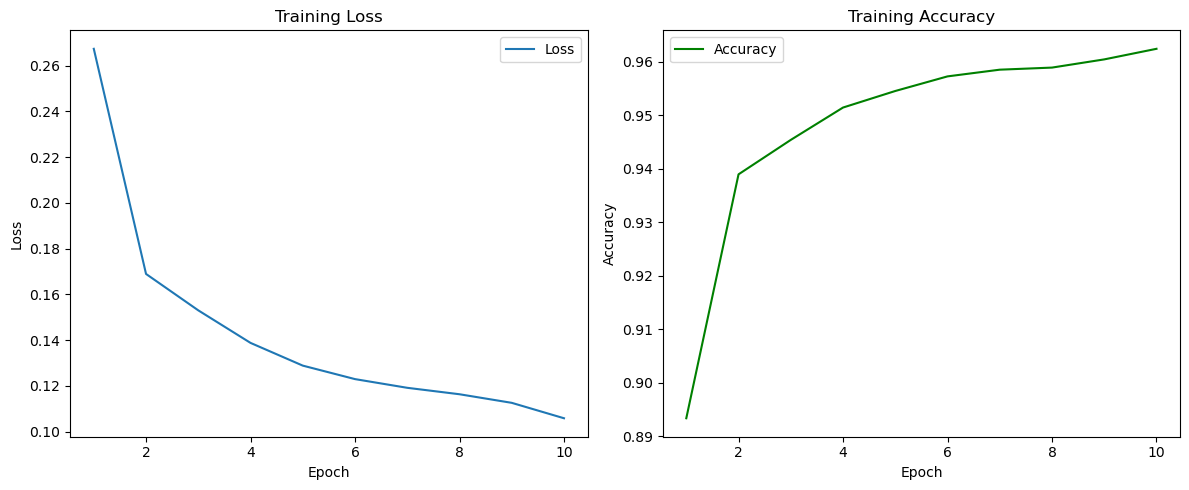

In [42]:
# Cell 14: Visualize Training Loss and Accuracy
def train_model_with_history(model, train_loader, criterion, optimizer, epochs=10, device='cpu'):
    model.to(device)
    model.train()
    history = {'loss': [], 'accuracy': []}
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_acc = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * X_batch.size(0)
            preds = (outputs >= 0.5).float()
            epoch_acc += (preds == y_batch).sum().item()
        
        epoch_loss /= len(train_loader.dataset)
        epoch_acc /= len(train_loader.dataset)
        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_acc)
        print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}')
    return history

# Retrain the best model and capture history
print("\nRetraining the best GloVe model with history tracking.")
model_best_history = FFNN(input_size=X_train_glove.shape[1], hidden_sizes=[best_hidden1, best_hidden2], dropout=dropout)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_best_history.parameters(), lr=best_lr)
history = train_model_with_history(model_best_history, train_loader_glove, criterion, optimizer, epochs, device)

# Plotting Loss and Accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), history['accuracy'], label='Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [43]:
# Cell 15: Error Analysis
# Get predictions and true labels
def get_predictions(model, test_loader, device='cpu'):
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []
    all_texts = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = (outputs >= 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.numpy())
    return all_preds, all_labels

# Assuming you have the test texts
test_texts = X_test.tolist()

# Get predictions
preds, labels = get_predictions(model_best, test_loader_glove, device)

# Create a DataFrame for analysis
analysis_df = pd.DataFrame({
    'Text': test_texts,
    'True Label': labels,
    'Predicted Label': preds
})

# Misclassified examples
misclassified = analysis_df[analysis_df['True Label'] != analysis_df['Predicted Label']]
print(f"Number of misclassified examples: {len(misclassified)}")

# Display some misclassified examples
print("\nSample Misclassified True News:")
print(misclassified[misclassified['True Label'] == 0]['Text'].iloc[:2])

print("\nSample Misclassified Fake News:")
print(misclassified[misclassified['True Label'] == 1]['Text'].iloc[:2])


Number of misclassified examples: 291

Sample Misclassified True News:
177    islamkot pakistan reuter pakistan bet cheap co...
196    london reuter project look link mental health ...
Name: Text, dtype: object

Sample Misclassified Fake News:
0     amateur presid donald trump hostil toward envi...
17    borderless travel europ die polit victim massm...
Name: Text, dtype: object
